In [1]:
import os

import torch
import torch.nn as nn
import torchvision
from torchvision import datasets
import torchvision.transforms as transforms
from torchvision.utils import make_grid

from sklearn.metrics import classification_report, confusion_matrix

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# **DATA LOADING**

In [2]:
# Const variables

DATASET_DIR_ROOT = "/content/drive/My Drive/eye-dataset"

In [4]:
from google.colab import drive

drive = drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Calculate Mean & STD(Standard Deviation) of Train dataset for Normalization

from torch.utils.data import DataLoader


train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])
train_set = datasets.ImageFolder(root=os.path.join(DATASET_DIR_ROOT, "train"), transform=train_transforms)
loader = DataLoader(train_set, batch_size=len(train_set), num_workers=1)
images, labels = next(iter(loader))
mean, std = images.mean([0,2,3]), images.std([0,2,3])  # [0.4215, 0.2807, 0.1708], [0.2942, 0.2172, 0.1634]

In [5]:
# Define transforms for each dataset separately

mean, std = [0.4215, 0.2807, 0.1708], [0.2942, 0.2172, 0.1634]
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(1),
    transforms.RandomRotation(45),
    transforms.RandomAdjustSharpness(1.3, 1),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std)
])

validation_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std)
])

test_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    # transforms.Normalize(mean, std)
])
  
denormalize_transforms = transforms.Compose([
    transforms.Normalize([0, 0, 0], [1/s for s in std]),
    transforms.Normalize([-m for m in mean], [1, 1, 1])
])

In [6]:
# Load datasets

train_set = datasets.ImageFolder(
    root=os.path.join(DATASET_DIR_ROOT, "train"),
    transform=train_transforms
)

validation_set = datasets.ImageFolder(
    root=os.path.join(DATASET_DIR_ROOT, "validation"),
    transform=validation_transforms
)

test_set = datasets.ImageFolder(
    root=os.path.join(DATASET_DIR_ROOT, "test"),
    transform=test_transforms
)

In [7]:
# Define Loaders

from torch.utils.data import DataLoader


batch_size = 32

train_loader = DataLoader(
    dataset=train_set,
    batch_size=batch_size,
    shuffle=True
)

validation_loader = DataLoader(
    dataset=validation_set,
    batch_size=batch_size,
    shuffle=False
)

test_loader = DataLoader(
    dataset=test_set,
    batch_size=batch_size,
    shuffle=False
)

# **DATA VISUALIZATION**  📊


In [8]:
sns.set_style('darkgrid')

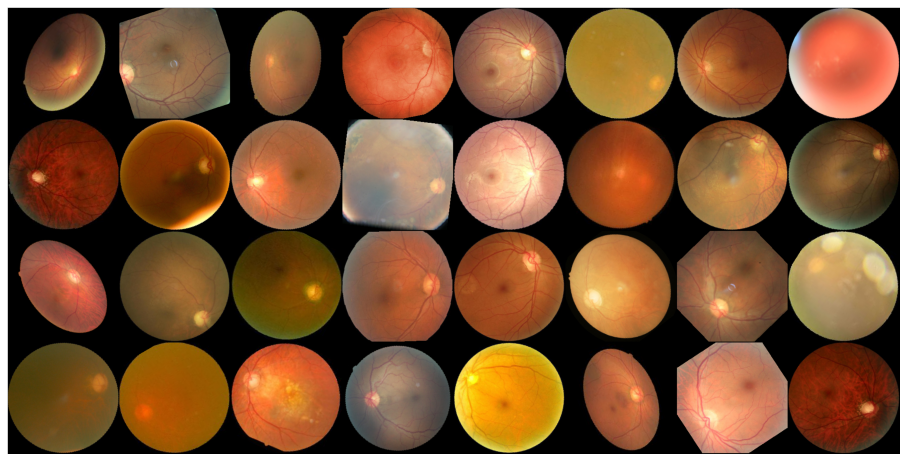

In [9]:
def grid_display(dataloader):
    """Plots a single batch of a dataloader. Denormalizes images for better visualization.

    :param dataloader: a DataLoader object that we want to display its images
    """
    for images, labels in dataloader:
        fig, ax = plt.subplots(figsize = (16,12))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=8).permute(1,2,0))
        break
        
grid_display(train_loader)

In [10]:
def label_distribution(dataset):
    """Counts the number of samples per label(class) in the dataset.
    
    :param dataset: the purpose dataset
    :type dataset: ImageFolder
    """
    encoded_labels = {v:k for k, v in dataset.class_to_idx.items()} # {0: 'cataract', 1: 'diabetic_retinopathy', 2: 'glaucoma', 3: 'normal'}
    labels_count = {k:0 for k in dataset.class_to_idx} # {'cataract': 0, 'diabetic_retinopathy': 0, 'glaucoma': 0, 'normal': 0}

    for label_code in encoded_labels:
        labels_count[encoded_labels[label_code]] = dataset.targets.count(label_code)
    return labels_count

In [11]:
def plot_from_dict(dict_obj: dict, plot_title: str, **kwargs):
    """Plots a bar chart from a dictionry. keys: x_axis, values: y_axis
    
    :param dict_obj: the dictionary that would be plotted
    :param plot_title: title of the plot
    """
    df = pd.DataFrame.from_dict([dict_obj]).melt()
    df.rename(columns={'variable': 'Dataset Labels', 'value': 'Number of samples'}, inplace=True)
    return sns.barplot(
        data=df,
        x="Dataset Labels",
        y="Number of samples",
        hue="Dataset Labels",
        **kwargs
    ).set_title(label=plot_title)

Text(0.5, 1.0, 'Test Set')

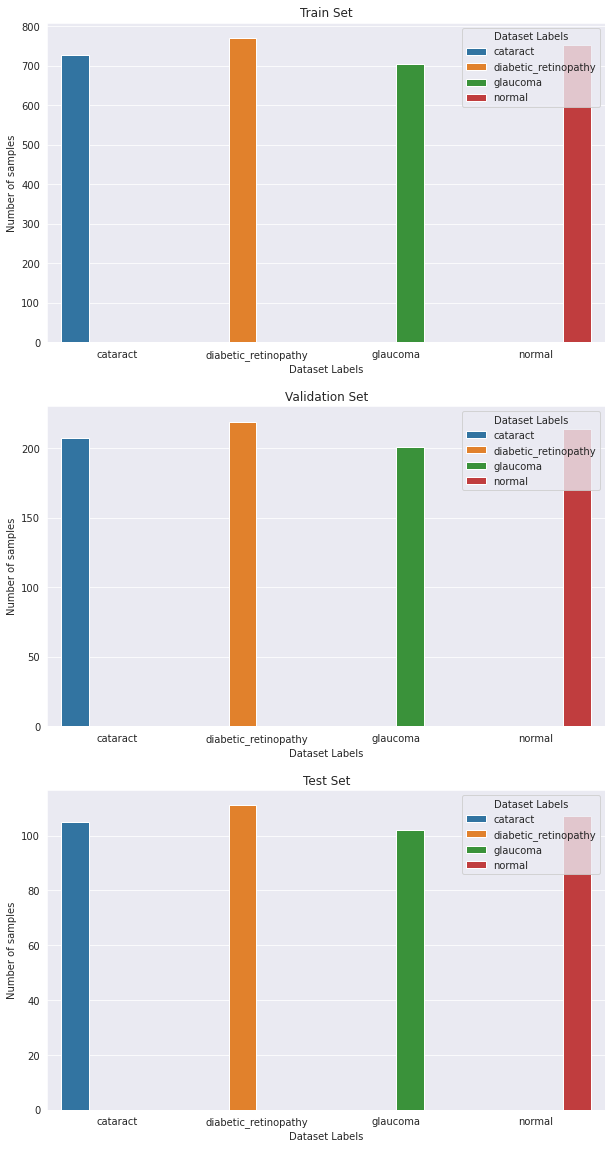

In [12]:
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 20))
plot_from_dict(label_distribution(train_set), plot_title="Train Set", ax=axes[0])
plot_from_dict(label_distribution(validation_set), plot_title="Validation Set", ax=axes[1])
plot_from_dict(label_distribution(test_set), plot_title="Test Set", ax=axes[2])

# **CNN MODEL**

In [18]:
len(train_set)

2954

In [13]:
# Define Model

class CNN(nn.Module):
    def __init__(self, k):
        super(CNN, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.fc = nn.Sequential(
            nn.Linear(64*30*30, 256),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(256, 128),
            nn.ReLU(),

            nn.Linear(128, k)
        )

    def forward(self, x):
        x = self.conv(x)
        x = x.view(-1, 64*30*30)
        x = self.fc(x)
        
        return x

In [14]:
# Define device : GPU or CPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
# Load model on the device

model = CNN(4)
model.to(device)

CNN(
  (conv): Sequential(
    (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
    (5): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (9): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): ReLU()
    (11): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=57600, out_features=256, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=256, out_features=128, bias=True)
    (4): ReLU()
    (5)

In [16]:
# Loss & Optimizer

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters())

# **TRAIN THE MODEL**

In [19]:
# Train model

import copy


n_epochs = 90
train_losses = np.zeros(n_epochs)
val_losses = np.zeros(n_epochs)
best_val_acc = 0.0


best_model_wts = copy.deepcopy(model.state_dict())

for epoch in range(n_epochs):
    train_corrects = 0
    train_loss = 0.0
    # train_loss = []
    model.train()
    for inputs, targets in train_loader:

        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        _, preds = torch.max(outputs, 1)
        train_corrects += torch.sum(preds == targets.data)
        train_loss += loss.item() * inputs.size(0)

        loss.backward()
        optimizer.step()
        
        # train_loss.append(loss.item())
    
    # train_loss = np.mean(train_loss)
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_corrects.double() / len(train_loader.dataset)
    
    with torch.no_grad():
        val_corrects = 0
        val_loss = 0.0
        model.eval()
        # val_loss = []
        for inputs, targets in validation_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)

            _, preds = torch.max(outputs, 1)
            val_corrects += torch.sum(preds == targets.data)
            val_loss += loss.item() * inputs.size(0)
            # val_loss.append(loss.item())
        
        # val_loss = np.mean(val_loss)
        val_loss = val_loss / len(validation_loader.dataset)
        val_acc = val_corrects.double() / len(validation_loader.dataset)

        if val_acc > best_val_acc:
          best_val_acc = val_acc
          best_model_wts = copy.deepcopy(model.state_dict())
    
    # save epoch losses
    train_losses[epoch] = train_loss
    val_losses[epoch] = val_loss
    
    print(f"Epoch {epoch+1}/{n_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")
    print('-'*30)

model.load_state_dict(best_model_wts)

Epoch 1/90:
Train Loss: 1.0541, Train Accuracy: 0.5711
Validation Loss: 0.8140, Validation Accuracy: 0.6766
------------------------------
Epoch 2/90:
Train Loss: 0.8111, Train Accuracy: 0.6534
Validation Loss: 0.7379, Validation Accuracy: 0.6813
------------------------------
Epoch 3/90:
Train Loss: 0.7343, Train Accuracy: 0.6916
Validation Loss: 1.0961, Validation Accuracy: 0.6136
------------------------------
Epoch 4/90:
Train Loss: 0.6372, Train Accuracy: 0.7295
Validation Loss: 0.6425, Validation Accuracy: 0.7253
------------------------------
Epoch 5/90:
Train Loss: 0.6108, Train Accuracy: 0.7404
Validation Loss: 0.6053, Validation Accuracy: 0.7622
------------------------------
Epoch 6/90:
Train Loss: 0.5598, Train Accuracy: 0.7674
Validation Loss: 0.5728, Validation Accuracy: 0.7586
------------------------------
Epoch 7/90:
Train Loss: 0.5491, Train Accuracy: 0.7640
Validation Loss: 0.5045, Validation Accuracy: 0.8098
------------------------------
Epoch 8/90:
Train Loss: 0.5

<All keys matched successfully>

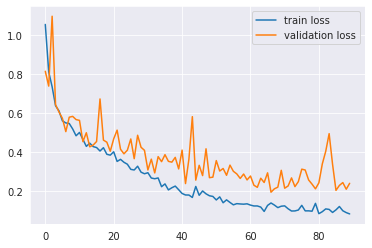

In [20]:
plt.plot(train_losses, label="train loss")
plt.plot(val_losses, label="validation loss")
plt.legend()
plt.show()

In [21]:
# Calculate Train and Validation Accuracy

def cal_accuracy(data_loader):
  n_correct = 0
  n_total = 0
  for inputs, targets in data_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)

    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

  accuracy = n_correct / n_total

  return accuracy


print(f"Train Accuracy: {cal_accuracy(train_loader):.4f}, Validation Accuracy: {cal_accuracy(validation_loader):.4f}, Test Accuracy: {cal_accuracy(test_loader):.4f}")

Train Accuracy: 0.9848, Validation Accuracy: 0.9501, Test Accuracy: 0.9576


#**TEST & EVALUATION**



In [22]:
y_true_list = []
y_pred_list = []

with torch.no_grad():
  for inputs, targets in test_loader:
    inputs = inputs.to(device)
    outputs = model(inputs)
    _, predictions = torch.max(outputs, 1)

    y_true_list.append(targets.cpu().numpy())
    y_pred_list.append(predictions.cpu().numpy())

# flatten data of batches into a 1-d list
y_true_list = list(np.concatenate(y_true_list).flat)
y_pred_list = list(np.concatenate(y_pred_list).flat)

In [23]:
# Classification Report

print(classification_report(y_true_list, y_pred_list))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96       105
           1       0.97      0.98      0.98       111
           2       0.95      0.91      0.93       102
           3       0.96      0.96      0.96       107

    accuracy                           0.96       425
   macro avg       0.96      0.96      0.96       425
weighted avg       0.96      0.96      0.96       425



In [24]:
# Confusion Matrix

print(confusion_matrix(y_true_list, y_pred_list))

[[102   0   3   0]
 [  0 109   1   1]
 [  6   0  93   3]
 [  0   3   1 103]]


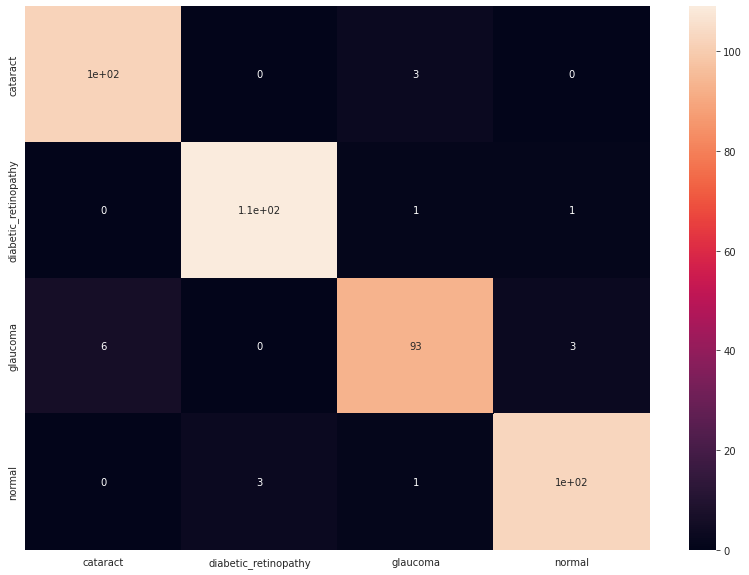

In [25]:
# Plot the Confusion Matrix

def plot_confusion_matrix(dataset, y_true_list, y_pred_list):
  index_to_label = {v:k for k, v in dataset.class_to_idx.items()}
  confusion_matrix_df = pd.DataFrame(confusion_matrix(y_true_list, y_pred_list)).rename(columns=index_to_label, index=index_to_label)
  fig, ax = plt.subplots(figsize=(14,10))         
  return sns.heatmap(confusion_matrix_df, annot=True, ax=ax)


plot_confusion_matrix(test_set, y_true_list, y_pred_list)

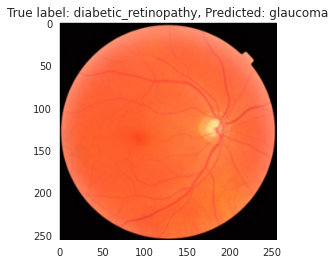

In [30]:
# Misclassified examples

encoded_labels = {v:k for k, v in train_set.class_to_idx.items()}
misclassified_idx = np.where(np.array(y_true_list) != np.array(y_pred_list))[0]
i = np.random.choice(misclassified_idx)
plt.imshow(test_set[i][0].permute(1, 2, 0))
plt.title(f"True label: {encoded_labels[y_true_list[i]]}, Predicted: {encoded_labels[y_pred_list[i]]}")
sns.set_style("dark")